#Toronto ETA Prediction
##by Datalopers
1. Abiyyu Fathin Derian
2. Alifia Cesarina Harmadi
3. Dhea Fajriati Anas
4. Hendri Prabowo
5. Nikolas Rakryan Widagdo


# Import Libraries, Mount to GDrive, and Install Geopandas

In [ ]:
# installing geopandas library
!pip install geopandas

     |████████████████████████████████| 994 kB 8.4 MB/s 
     |████████████████████████████████| 6.6 MB 25.8 MB/s 
     |████████████████████████████████| 15.4 MB 37 kB/s 


In [ ]:
# importing relevant libraries

# General Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
import random
import pickle
import os.path
%matplotlib inline

# Geospatial Data Processing Libraries
from shapely.geometry import Point
import geopy.distance
import shapely
import geopandas as gpd

# Modelling Libraries
import xgboost as xgb
import lightgbm as lgb
from sklearn import tree
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

# mounting gdrive to google colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Reading Inputs

Here, we input Toroto Travel time data for January 2020 to March 2020 and use Zone Type of Neighbourhoods.

We'll consider the hourly travel time average for modelling.

In [ ]:
# read csv files of Toronto Travel Times and Toronto Travel Time by Hour of Day (All Days)
travel_times = pd.read_csv('/content/drive/MyDrive/SupervisedLearningScriptandMaterial/Toronto/Dataset/Travel_Times.csv')
toronto_hourly = pd.read_csv('/content/drive/MyDrive/SupervisedLearningScriptandMaterial/Toronto/Dataset/toronto-neighbourhoods-2020-1-All-HourlyAggregate.csv')

In [ ]:
# Check travel_times dataframe
travel_times.head(2)

,Origin Movement ID,Origin Display Name,Destination Movement ID,Destination Display Name,Date Range,Mean Travel Time (Seconds),Range - Lower Bound Travel Time (Seconds),Range - Upper Bound Travel Time (Seconds)
0,113,"Saint Basil Lane, Bay Cloverhill, Old Toronto,...",1,"York University Busway, York University Height...","3/1/2020 - 3/31/2020, Every day, Daily Average",1870,1405,2487
1,113,"Saint Basil Lane, Bay Cloverhill, Old Toronto,...",2,"0 Hambly Avenue, The Beach, Old Toronto, Toronto","3/1/2020 - 3/31/2020, Every day, Daily Average",886,635,1235


In [ ]:
# Check toronto_hourly dataframe
toronto_hourly.head(2)

,sourceid,dstid,hod,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time
0,33,135,7,2333.88,884.45,2188.31,1.42
1,132,12,7,1095.12,242.96,1068.57,1.25


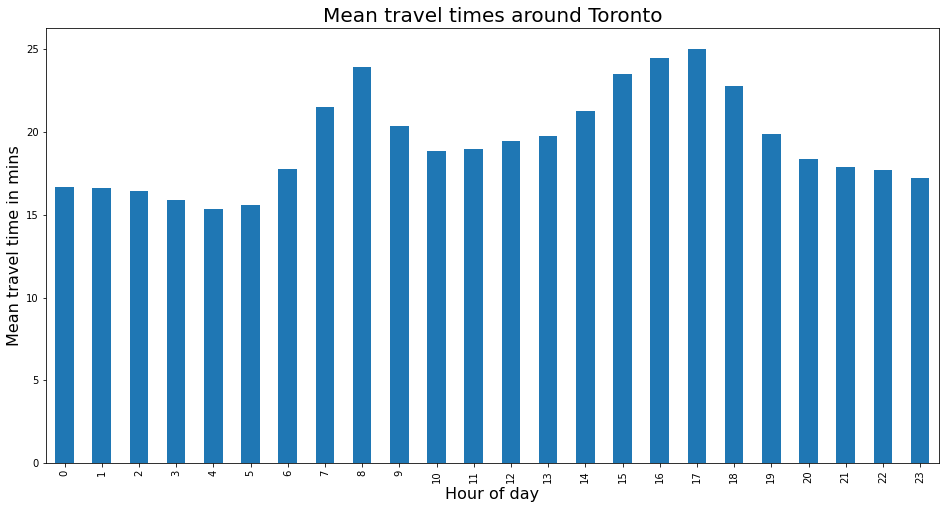

In [ ]:
# visualise Mean Travel Times in Mins per Hour in Toronto
mean_travel_time_by_hour_of_day = toronto_hourly.groupby('hod')['mean_travel_time'].mean()/60
plt = mean_travel_time_by_hour_of_day.plot(kind="bar", figsize=(16,8))
plt.set_title('Mean travel times around Toronto',fontsize=20)
plt.set_xlabel('Hour of day', fontsize=16)
_ = plt.set_ylabel('Mean travel time in mins', fontsize=16)

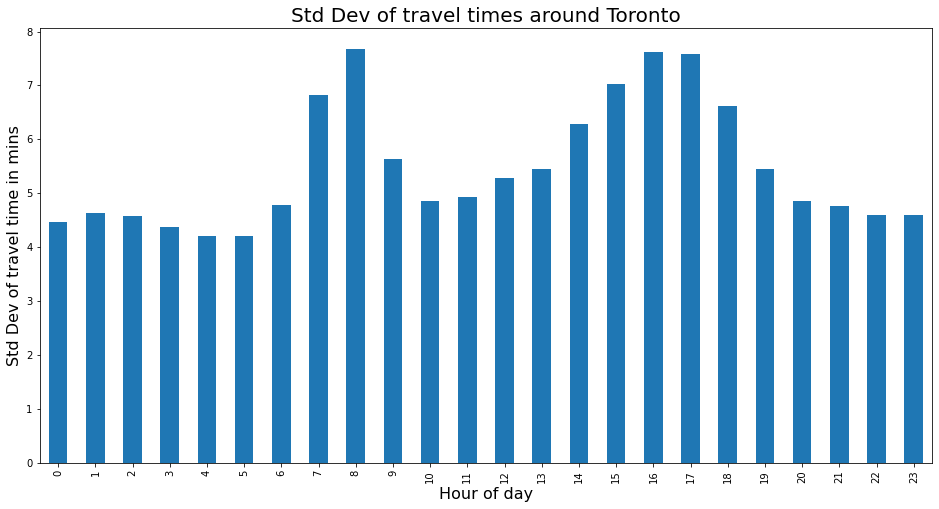

In [ ]:
# visualise Std of Travel Times in Mins per Hour in Toronto
std_dev_time_by_hour_of_day = toronto_hourly.groupby('hod')['standard_deviation_travel_time'].mean()/60
plt = std_dev_time_by_hour_of_day.plot(kind="bar", figsize=(16,8))
plt.set_title('Std Dev of travel times around Toronto',fontsize=20)
plt.set_xlabel('Hour of day', fontsize=16)
_ = plt.set_ylabel('Std Dev of travel time in mins', fontsize=16)

# The Neighbourhoods data

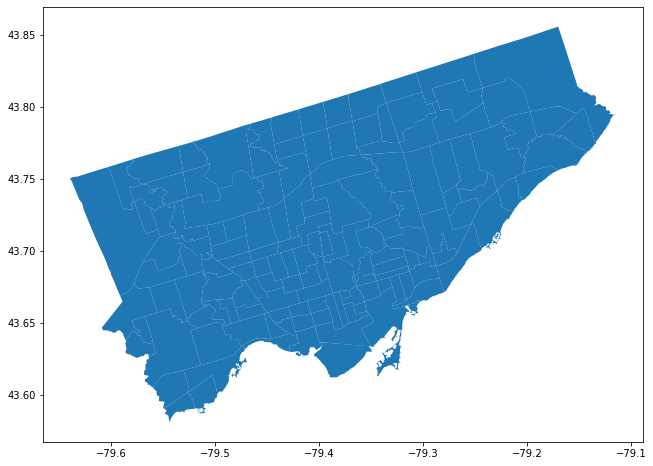

In [ ]:
# read and visualise Toronto geospatial map
toronto=gpd.read_file('/content/drive/MyDrive/SupervisedLearningScriptandMaterial/Toronto/Dataset/toronto_neighbourhoods.json')
toronto.plot(figsize=(16,8))

In [ ]:
# check Toronto Geospatial Dataframe
toronto.head()

,MOVEMENT_ID,DISPLAY_NAME,geometry
0,1,"York University Busway, York University Height...","MULTIPOLYGON (((-79.50529 43.75987, -79.50488 ..."
1,2,"0 Hambly Avenue, The Beach, Old Toronto, Toronto","MULTIPOLYGON (((-79.31485 43.66674, -79.31356 ..."
2,3,"3400 Kingston Road, Scarborough Village, Scarb...","MULTIPOLYGON (((-79.21397 43.72676, -79.21400 ..."
3,4,"100 Dunn Avenue, Parkdale, Old Toronto, Toronto","MULTIPOLYGON (((-79.42777 43.62979, -79.42948 ..."
4,5,"0 Carlaw Avenue, Leslieville, Old Toronto, Tor...","MULTIPOLYGON (((-79.32868 43.64745, -79.32867 ..."


# Picking centroids to represent an area

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  after removing the cwd from sys.path.


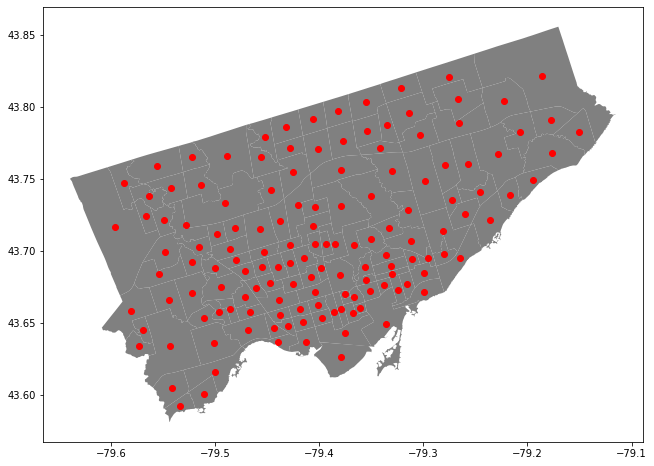

In [ ]:
# copy Toronto data and show the centroid of the neighbourhoods 
toronto = toronto.drop(columns=['MOVEMENT_ID'])
toronto_c = toronto.copy()
toronto_c.geometry = toronto_c['geometry'].centroid
fig, ax = plot.subplots(figsize=(16,8))
toronto.plot(color='grey',ax=ax)
toronto_c.plot(color='red',ax=ax)

In [ ]:
# create new dataframe from columns of 'Destination Movement ID' and 'Destination Display Name' in travel_times 
id_to_dest = travel_times[['Destination Movement ID', 'Destination Display Name']]
id_to_dest.columns = ['id', 'name']
id_to_dest.head()

,id,name
0,1,"York University Busway, York University Height..."
1,2,"0 Hambly Avenue, The Beach, Old Toronto, Toronto"
2,3,"3400 Kingston Road, Scarborough Village, Scarb..."
3,4,"100 Dunn Avenue, Parkdale, Old Toronto, Toronto"
4,5,"0 Carlaw Avenue, Leslieville, Old Toronto, Tor..."


# Get some random points from each neighbourhood to diversify representation

In [ ]:
# The number of rows with random points to be created corresponding to each row in source df
number = 3

# create 'random_points_in_polygon' function with parameter of number and polygon, return points
def random_points_in_polygon(number, polygon):
    points = []
    min_x, min_y, max_x, max_y = polygon.bounds # use .bounds to return the Min Max of polygon
    i= 0
    while i < number:
        point = Point(random.uniform(min_x, max_x), random.uniform(min_y, max_y))
        if polygon.contains(point):
            points.append(point)
            i += 1
    return points

# create 'diversify_geo_data' function with parameter df, return new df
def diversify_geo_data(df):
    new_df = gpd.GeoDataFrame()
    common_columns = df.columns
    common_columns.tolist().remove('geometry') # list of the columns in data except 'geometry'
    for row in df.itertuples():
        points = random_points_in_polygon(number, row.geometry)
        for point in points:
            tmp = gpd.GeoDataFrame(columns=df.columns, data=[list(row[1:2]) + [point]])
            new_df = new_df.append(tmp, ignore_index=True)
    return new_df
            
# create new data from diversifying the Toronto Dataframe
diversified_points = diversify_geo_data(toronto)
diversified_points.sample(5)

,DISPLAY_NAME,geometry
185,"0 Nairn Avenue, Earlscourt, York, Toronto",POINT (-79.44233 43.67505)
382,"200 Queen Street East, Downtown, Old Toronto, ...",POINT (-79.36775 43.65408)
62,"0 Norwood Road, Upper Beaches, Old Toronto, To...",POINT (-79.29425 43.68907)
350,"300 Passmore Avenue, Armdale, Scarborough, Tor...",POINT (-79.26439 43.81959)
230,"0 Four Oaks Gate, Old East York, East York, To...",POINT (-79.34762 43.69401)


In [ ]:
# check data shape of diversified_points
diversified_points.shape

(423, 2)

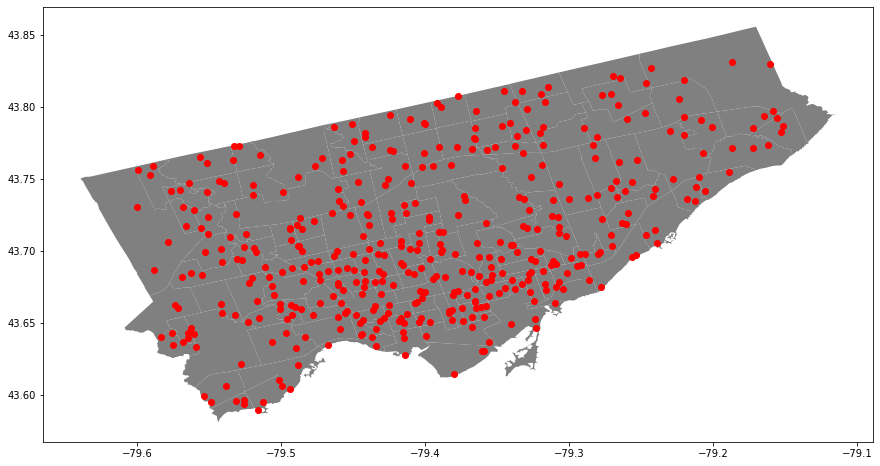

In [ ]:
# visualise diversified random points
fig, ax = plot.subplots(figsize=(16,8))
toronto.plot(color='grey',ax=ax)
diversified_points.plot(color='red',ax=ax)

# Cleaning up data for analysis

Got source and destination data and removed unneeded columns like geometric_mean_travel_time and geometric_standard_deviation_travel_time.

In [ ]:
# create new df with toronto_hourly and id_to_dest to get the source and destination data
time_df = pd.merge(toronto_hourly, id_to_dest, left_on=['sourceid'], right_on=['id'], how='inner') # for source data
time_df = time_df.drop(columns=['id', 'geometric_mean_travel_time', 'geometric_standard_deviation_travel_time'])
time_df = time_df.rename(columns={'name': 'Source Name'})
time_df = pd.merge(time_df, id_to_dest, left_on=['dstid'], right_on=['id'], how='inner') # for destination data
time_df = time_df.drop(columns=['id'])
time_df = time_df.rename(columns={'name': 'Destination Name'})
time_df = time_df.sort_values(by=['sourceid', 'dstid', 'hod'])
time_df.tail(5)

,sourceid,dstid,hod,mean_travel_time,standard_deviation_travel_time,Source Name,Destination Name
279984,141,140,20,1518.76,284.21,"Water's Edge Promenade, Downtown, Old Toronto,...","900 York Beltline Trail, Briar Hill - Belgravi..."
279974,141,140,21,1528.77,300.13,"Water's Edge Promenade, Downtown, Old Toronto,...","900 York Beltline Trail, Briar Hill - Belgravi..."
279980,141,140,22,1481.58,303.79,"Water's Edge Promenade, Downtown, Old Toronto,...","900 York Beltline Trail, Briar Hill - Belgravi..."
279972,141,140,23,1431.77,301.57,"Water's Edge Promenade, Downtown, Old Toronto,...","900 York Beltline Trail, Briar Hill - Belgravi..."
369895,141,141,23,297.76,229.63,"Water's Edge Promenade, Downtown, Old Toronto,...","Water's Edge Promenade, Downtown, Old Toronto,..."


In [ ]:
# check time_df data shape
time_df.shape

(395886, 7)

In [ ]:
# check toronto_c data shape
toronto_c.shape

(141, 2)

In [ ]:
# check diversified_points data shape
diversified_points.shape

(423, 2)

In [ ]:
# append diverisfied_points data to toronto_c and store it to full_toronto
full_toronto = toronto_c.append(diversified_points, ignore_index=True)
full_toronto.shape #check its shape

(564, 2)

In [ ]:
# get the geometry of source and destination by merging the time_df and full_toronto data
time_df2 = pd.merge(time_df, full_toronto, left_on=['Source Name'], right_on=['DISPLAY_NAME'], how='inner')
time_df2 = time_df2.drop(columns=['DISPLAY_NAME'])
time_df2 = time_df2.rename(columns = {'WARD_NAME': 'Source Ward Name', 'geometry': 'Source Geometry'})
time_df2 = pd.merge(time_df2, full_toronto, left_on=['Destination Name'], right_on=['DISPLAY_NAME'], how='inner')
time_df2 = time_df2.drop(columns=['DISPLAY_NAME'])
time_df2 = time_df2.rename(columns = {'WARD_NAME': 'Destination Ward Name', 'geometry': 'Destination Geometry'})
time_df2.sample(3)

,sourceid,dstid,hod,mean_travel_time,standard_deviation_travel_time,Source Name,Destination Name,Source Geometry,Destination Geometry
1620788,77,40,1,1358.39,431.09,"0 Four Oaks Gate, Old East York, East York, To...","0 Densley Avenue, Brookhaven - Amesbury, North...",POINT (-79.32028 43.69974),POINT (-79.48559 43.70133)
1704180,47,42,11,429.30,222.64,"0 Navenby Crescent, Humber Summit, North York,...","0 Erie Street, Maple Leaf, North York, Toronto",POINT (-79.55173 43.76068),POINT (-79.48076 43.71557)
3122474,134,74,7,210.40,116.63,"100 Wedgewood Drive, Newtonbrook, North York, ...","0 Beardmore Crescent, Newtonbrook, North York,...",POINT (-79.41030 43.79138),POINT (-79.37707 43.80729)


In [ ]:
# check time_df2 data shape
time_df2.shape

(6334176, 9)

The number of row in time_df was 395886 but it was dramatically increased in time_df2 to be 6334176 rows. This happened because there were 4 different number of points in each neighbourhood. 

The 'mean_travel_time' was copied from previous neighbourhood data as it was still in the same source and destination id. The change was only in the geometry columns.

In [ ]:
# create function to save the output files
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

# create function to return the file path if the file exists
def file_exists(filename):
    return os.path.exists(filename)

input_path = '/content/drive/MyDrive/SupervisedLearningScriptandMaterial/Toronto/Output/'

# Calculating distances to use as a feature

In [ ]:
# create function to calculate the distance between Source and Destination
def calc_distance(x):
    src_point = (x['Source Geometry'].y, x['Source Geometry'].x)
    dest_point = (x['Destination Geometry'].y, x['Destination Geometry'].x)
    return geopy.distance.geodesic(src_point, dest_point).kilometers

filename = 'Df_for_modelling.bin'
path = input_path + filename

#print(file_exists(path))

if file_exists(path):
    # skip to next section since the results here are already precalculated
    pass
else:
    print('Creating distance file')
    # create new calculation of distance if the file is not available
    time_df2['Geodesic Distance'] = time_df2.apply(func = calc_distance, axis=1)
    df = time_df2


In [ ]:
# create the final dataframe for modelling
filename = 'Df_for_modelling.bin'
path = input_path + filename
if file_exists(path):
    with open(path, 'rb') as file:
        final_df = pickle.load(file)
else:
    print('Creating final df file')
    final_df = df.copy() # create new final dataframe id the file is not available
    final_df['Source lat'] = final_df['Source Geometry'].apply(lambda pt: float(pt.y))
    final_df['Source long'] = final_df['Source Geometry'].apply(lambda pt: float(pt.x))
    final_df['Dest lat'] = final_df['Destination Geometry'].apply(lambda pt: float(pt.y))
    final_df['Dest long'] = final_df['Destination Geometry'].apply(lambda pt: float(pt.x))

# determine the feature columns and target/outcome column
features = ['Source lat', 'Source long', 'Dest lat', 'Dest long', 'hod', 'Geodesic Distance']
outcome = ['mean_travel_time']
final_df = final_df[features + outcome]

try:
    save_object(final_df, input_path + filename) # save the data file
except:
    pass

# Modelling

In [ ]:
# split data to X_train, X_test, y_train, y_test
X = final_df[features]
y = final_df[outcome]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)


## XGBoost

In [ ]:
# open or create XGBoost model
filename = 'XGB_model_5.bin'
path = input_path + filename
if file_exists(path):
    with open(path, 'rb') as file:
        my_model = pickle.load(file)
else:
    my_model = xgb.XGBRegressor(n_estimators=300, learning_rate=0.083, n_jobs=4, objective='reg:squarederror')
    my_model.fit(X_train, y_train,verbose=False)
    
try:    
    save_object(X_train, 'train_set_x.bin')
    save_object(y_train, 'train_set_y.bin')
    save_object(X_test, 'test_set_x.bin')
    save_object(y_test, 'test_set_y.bin')
    save_object(my_model, input_path + filename)
except:
    pass

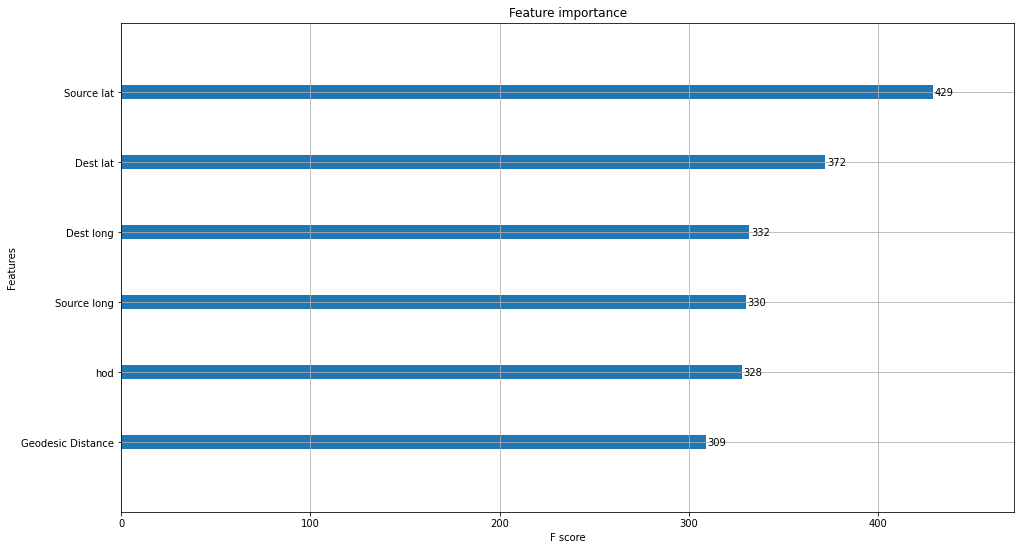

In [ ]:
# visualise the importance of feature in F-score metric
ax = xgb.plot_importance(my_model)
fig = ax.figure
fig.set_size_inches(16, 9)

In [ ]:
# check overfitting in the training data
predictions = my_model.predict(X_train)

# print the metric evaluations
r2 = metrics.r2_score(y_train, predictions)
print('R2: {}\n'.format(r2))

mse = metrics.mean_squared_error(y_train, predictions)
print('MSE: {}\n'.format(mse))

print('RMSE: {}\n'.format(np.sqrt(mse)))

mae = metrics.mean_absolute_error(y_train, predictions)
print('MAE: {}\n'.format(mae))

R2: 0.8144112286016941

MSE: 53018.6563680756

RMSE: 230.2578041415222

MAE: 177.96039231292502



In [ ]:
# check overfitting in the test data
predictions = my_model.predict(X_test)

# print the metric evaluations
r2 = metrics.r2_score(y_test, predictions)
print('R2: {}\n'.format(r2))

mse = metrics.mean_squared_error(y_test, predictions)
print('MSE: {}\n'.format(mse))

print('RMSE: {}\n'.format(np.sqrt(mse)))

mae = metrics.mean_absolute_error(y_test, predictions)
print('MAE: {}\n'.format(mae))


R2: 0.8142916301326019

MSE: 53069.07395099708

RMSE: 230.3672588520276

MAE: 178.0341882767593



/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


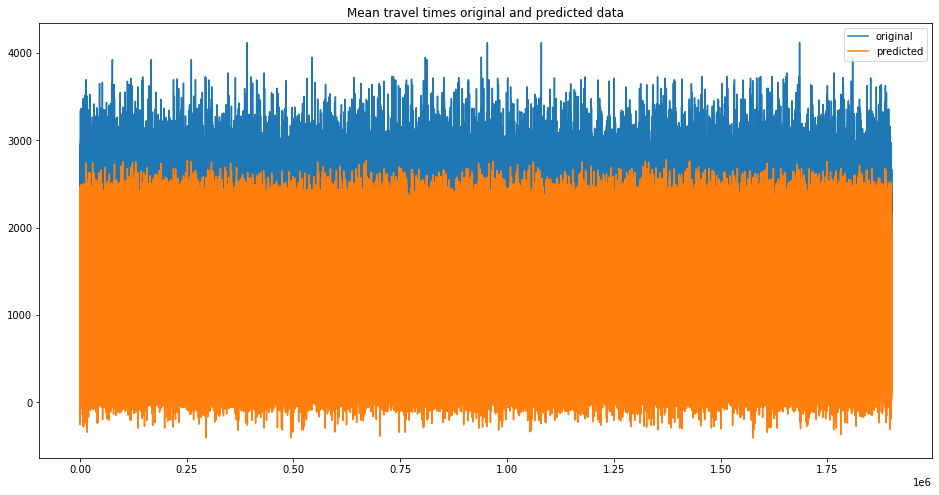

In [ ]:
# visualise the original mean travel times with predicted data
plot.figure(figsize = (16, 8))
x_ax = range(len(y_test))
plot.plot(x_ax, y_test, label="original")
plot.plot(x_ax, predictions, label="predicted")

plot.title("Mean travel times original and predicted data")

plot.legend()
plot.show()

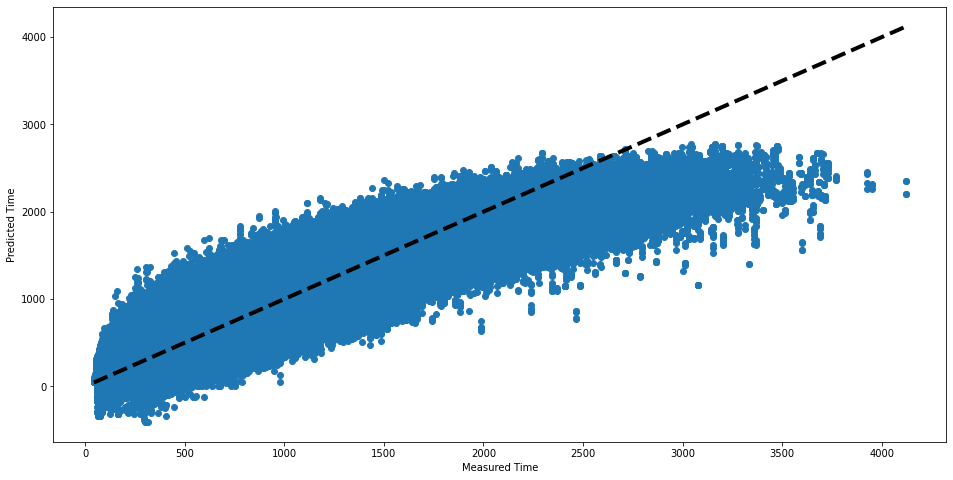

In [ ]:
# visualise scatterplot of measured time vs predicted time
fig, ax = plot.subplots(figsize=(16,8))
ax.scatter(y_test, predictions)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured Time')
ax.set_ylabel('Predicted Time')
plot.show()

## Lightgbm

In [ ]:
# open or create LightGBM model
filename = 'LightGBM_model_5.bin'
path = input_path + filename
if file_exists(path):
    with open(path, 'rb') as file:
        model = pickle.load(file)
else:
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_test, y_test)

    params = {
      'boosting_type': 'gbdt',
      'metric': 'rmse',
      'objective': 'regression',
      'n_jobs': -1,
      'seed': 236,
      'learning_rate': 0.05,
      'bagging_fraction': 0.75,
      'bagging_freq': 10, 
      'colsample_bytree': 0.75}

    model = lgb.train(params, lgb_train, num_boost_round=2500, early_stopping_rounds=100, valid_sets = [lgb_train, lgb_eval], verbose_eval=100)
try:    
    save_object(model, input_path + filename)
except:
    pass

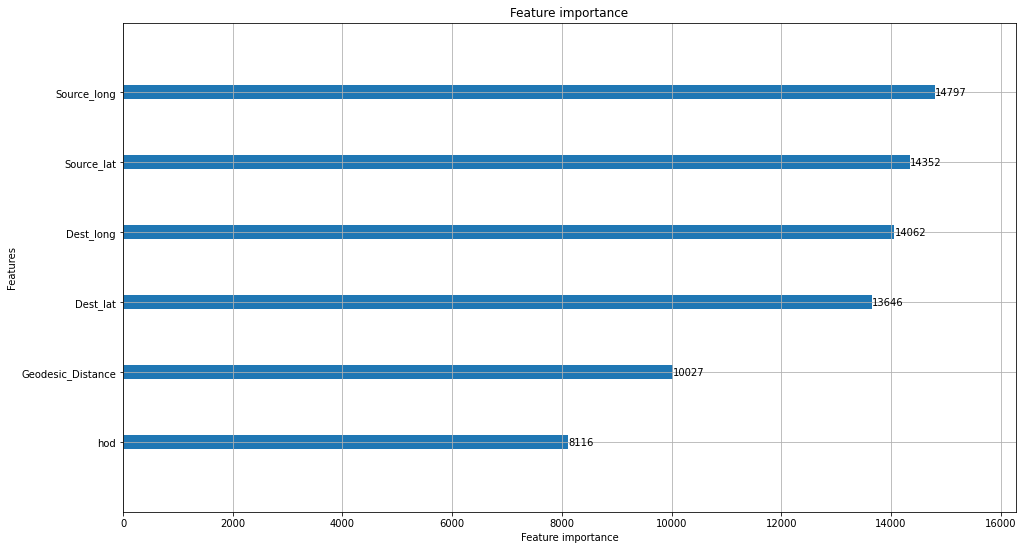

In [ ]:
# visualise the importance of feature in F-score metric
ax = lgb.plot_importance(model)
fig = ax.figure
fig.set_size_inches(16, 9)

In [ ]:
# check overfitting in the training data
predictions = model.predict(X_train)

# print the metric evaluations
r2 = metrics.r2_score(y_train, predictions)
print('R2: {}\n'.format(r2))

mse = metrics.mean_squared_error(y_train, predictions)
print('MSE: {}\n'.format(mse))

print('RMSE: {}\n'.format(np.sqrt(mse)))

mae = metrics.mean_absolute_error(y_train, predictions)
print('MAE: {}\n'.format(mae))

R2: 0.9484179875424467

MSE: 14735.853751579816

RMSE: 121.39132486129236

MAE: 90.28884819006086



In [ ]:
# check overfitting in the test data
predictions = model.predict(X_test)

# print the metric evaluations
r2 = metrics.r2_score(y_test, predictions)
print('R2: {}\n'.format(r2))

mse = metrics.mean_squared_error(y_test, predictions)
print('MSE: {}\n'.format(mse))

print('RMSE: {}\n'.format(np.sqrt(mse)))

mae = metrics.mean_absolute_error(y_test, predictions)
print('MAE: {}\n'.format(mae))

R2: 0.9480914366469917

MSE: 14833.684605803128

RMSE: 121.79361479898331

MAE: 90.56814584464905



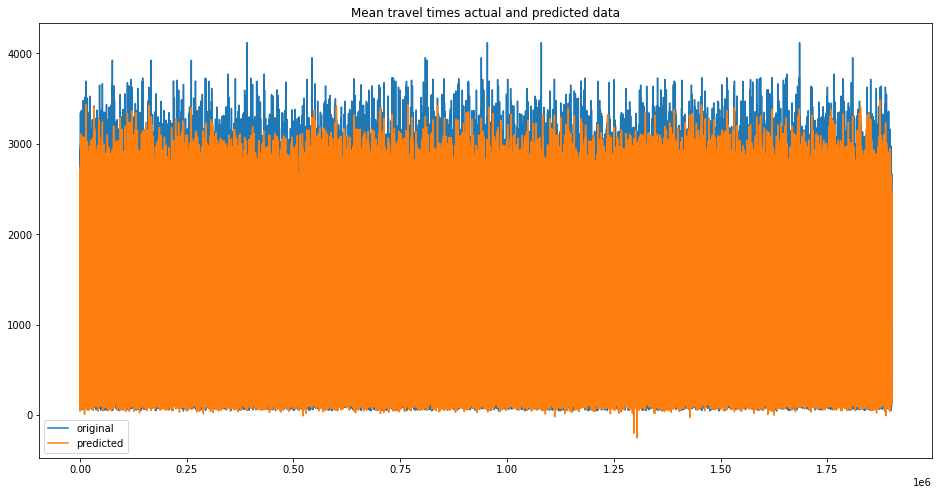

In [ ]:
# visualise the original mean travel times with predicted data
plot.figure(figsize = (16, 8))
x_ax = range(len(y_test))
plot.plot(x_ax, y_test, label="original")
plot.plot(x_ax, predictions, label="predicted")

plot.title("Mean travel times original and predicted data")

plot.legend()
plot.show()

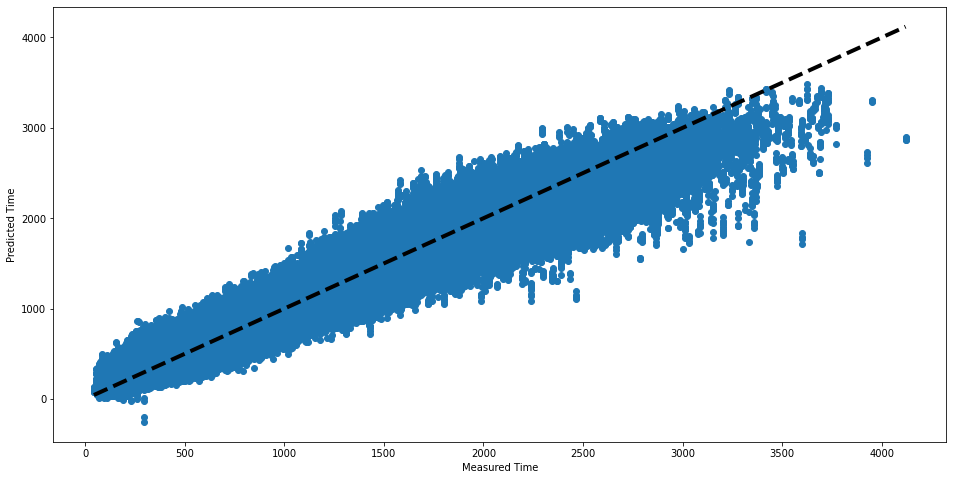

In [ ]:
# visualise scatterplot of measured time vs predicted time
fig, ax = plot.subplots(figsize = (16, 8))
ax.scatter(y_test, predictions)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured Time')
ax.set_ylabel('Predicted Time')
plot.show()

## KNN

In [ ]:
# open or create KNN model
filename = 'KNN_model_5.bin'
path = input_path + filename
if file_exists(path):
    with open(path, 'rb') as file:
        my_model1 = pickle.load(file)
else:
    my_model1 = KNeighborsRegressor(n_neighbors=10)
    my_model1.fit(X_train, y_train)
    
try:    
    save_object(my_model1, input_path + filename)
except:
    pass

In [ ]:
# check overfitting in the training data
predictions = my_model1.predict(X_train)

# print the metric evaluations
r2 = metrics.r2_score(y_train, predictions)
print('R2: {}\n'.format(r2))

mse = metrics.mean_squared_error(y_train, predictions)
print('MSE: {}\n'.format(mse))

print('RMSE: {}\n'.format(np.sqrt(mse)))

mae = metrics.mean_absolute_error(y_train, predictions)
print('MAE: {}\n'.format(mae))

R2: 0.8686729834415274

MSE: 37517.25877755226

RMSE: 193.69372415633984

MAE: 147.6347117902136



In [ ]:
# check overfitting in the test data
predictions = my_model1.predict(X_test)

# print the metric evaluations
r2 = metrics.r2_score(y_test, predictions)
print('R2: {}\n'.format(r2))

mse = metrics.mean_squared_error(y_test, predictions)
print('MSE: {}\n'.format(mse))

print('RMSE: {}\n'.format(np.sqrt(mse)))

mae = metrics.mean_absolute_error(y_test, predictions)
print('MAE: {}\n'.format(mae))


R2: 0.8363944117577196

MSE: 46752.858082947314

RMSE: 216.22409228147384

MAE: 164.89411278603436



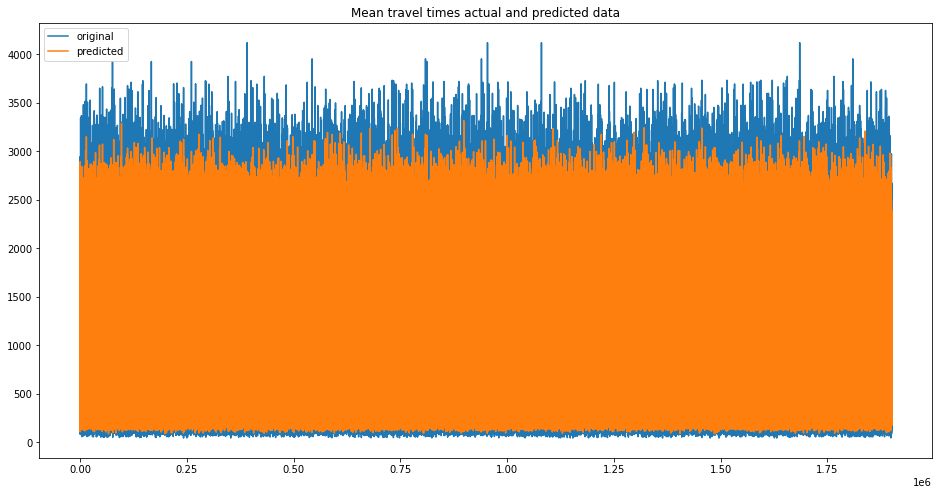

In [ ]:
# visualise the original mean travel times with predicted data
plot.figure(figsize = (16, 8))
x_ax = range(len(y_test))
plot.plot(x_ax, y_test, label="original")
plot.plot(x_ax, predictions, label="predicted")

plot.title("Mean travel times original and predicted data")

plot.legend()
plot.show()

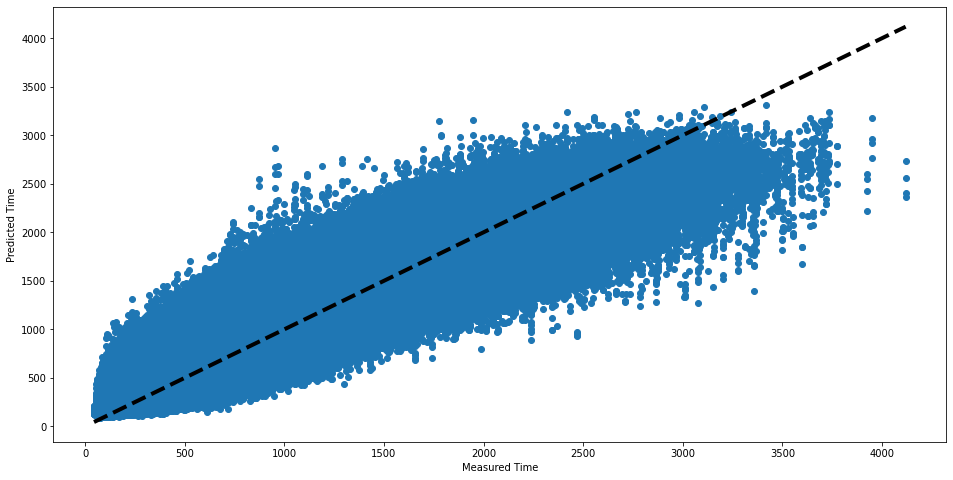

In [ ]:
# visualise scatterplot of measured time vs predicted time
fig, ax = plot.subplots(figsize = (16, 8))
ax.scatter(y_test, predictions)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured Time')
ax.set_ylabel('Predicted Time')
plot.show()

# Experiment Report

We tried to predict the mean travel time with random forest algorithm but the google colab crashed. We assumed that there were too many trees being generated. We proved this by checking the tree using decision trees algorithm.

## Decision Tree

In [ ]:
# create the Decision Tree Model
regressor = DecisionTreeRegressor(random_state = 0)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

In [ ]:
# show the tree in text representation
text_representation = tree.export_text(regressor)
print(text_representation)

|--- feature_5 <= 7.84
|   |--- feature_5 <= 4.57
|   |   |--- feature_5 <= 2.86
|   |   |   |--- feature_5 <= 1.99
|   |   |   |   |--- feature_5 <= 1.39
|   |   |   |   |   |--- feature_4 <= 6.50
|   |   |   |   |   |   |--- feature_5 <= 1.10
|   |   |   |   |   |   |   |--- feature_0 <= 43.72
|   |   |   |   |   |   |   |   |--- feature_1 <= -79.31
|   |   |   |   |   |   |   |   |   |--- feature_1 <= -79.54
|   |   |   |   |   |   |   |   |   |   |--- feature_2 <= 43.65
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 6
|   |   |   |   |   |   |   |   |   |   |--- feature_2 >  43.65
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 6
|   |   |   |   |   |   |   |   |   |--- feature_1 >  -79.54
|   |   |   |   |   |   |   |   |   |   |--- feature_1 <= -79.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 20
|   |   |   |   |   |   |   |   |   |   |--- feature_1 >  -79.50
|   |   |   |   |   |   |   |   | 

# Conclusion

After conducting several experiments with 5 algorithms, we conclude that LightGBM is the best performing model to predict the mean travel time based on R-squared (0.94). We recommend this model to use for building an ETA prediction system.